# Step 3: Reproducing Research

In this step I try to reproduce some of the research techniques that I found


## Loading data.

For starters we just load the data like we did in the previous notebook.

In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import pathlib
import os.path

data_dir =  pathlib.Path(os.path.abspath("images/Flowers5/"))
data_dir

WindowsPath('E:/school/UCSD-ML-Capstone/images/Flowers5')

In [3]:
batch_size = 32
epochs=10
img_height = 192
img_width = 192
input_shape=(img_height, img_width, 3)

In [4]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split=0.2, subset="both", seed=123,
                                                               image_size=(img_height, img_width), batch_size=batch_size)

Found 1857 files belonging to 5 classes.
Using 1486 files for training.
Using 371 files for validation.


In [5]:
class_names = train_ds.class_names
num_classes = len(class_names)
num_classes
print(class_names)

['Calceolaria', 'Daffodil', 'Freesia', 'Hibiscus', 'Iris']


## BigTransfer (BiT) 

BigTransfer has a special recipe for generalizing transfer learning. Let's see how well it works.

In [6]:
import tensorflow_hub as hub

# Load model into KerasLayer
model_url = "https://tfhub.dev/google/bit/m-r50x1/ilsvrc2012_classification/1"
imagenet_module = hub.KerasLayer(model_url)

In [7]:
# This is the transfer formula specified by the BiT example code.
SCHEDULE_BOUNDARIES = [200, 300, 400]
lr = 0.003 * batch_size / 512 
# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [8]:
bit_model = tf.keras.Sequential([
        layers.Rescaling(1./255), imagenet_module, layers.Flatten(), layers.Dense(64, activation='relu'), layers.Dropout(0.2), layers.Dense(num_classes),
    ])

bit_model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
bit_model.build((None, img_height, img_width, 3))
bit_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 192, 192, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1000)              25549352  
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 64)                64064     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 25,613,741
Trainable params: 64,389
Non-tr

In [9]:
bit_history = bit_model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
47/47 [==============================] - 111s 2s/step - loss: 1.6965 - accuracy: 0.4596 - val_loss: 0.7284 - val_accuracy: 0.7709
Epoch 2/10
47/47 [==============================] - 100s 2s/step - loss: 0.7895 - accuracy: 0.7342 - val_loss: 0.4826 - val_accuracy: 0.8275
Epoch 3/10
47/47 [==============================] - 100s 2s/step - loss: 0.5745 - accuracy: 0.8069 - val_loss: 0.3826 - val_accuracy: 0.8652
Epoch 4/10
47/47 [==============================] - 100s 2s/step - loss: 0.4494 - accuracy: 0.8520 - val_loss: 0.3203 - val_accuracy: 0.8922
Epoch 5/10
47/47 [==============================] - 100s 2s/step - loss: 0.4028 - accuracy: 0.8641 - val_loss: 0.2985 - val_accuracy: 0.9030
Epoch 6/10
47/47 [==============================] - 100s 2s/step - loss: 0.3760 - accuracy: 0.8748 - val_loss: 0.2947 - val_accuracy: 0.9111
Epoch 7/10
47/47 [==============================] - 100s 2s/step - loss: 0.3711 - accuracy: 0.8775 - val_loss: 0.2926 - val_accuracy: 0.9111
Epoch 8/10
47

## Compact Convolutional Transformers

This applies the method from [Escaping the Big Data Paradigm with Compact Transformers](https://arxiv.org/abs/2104.05704) on our flowers dataset. The code was adapted from this [Colab entry](https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/cct.ipynb#scrollTo=eF0yjK1pXfpK)

In [10]:
from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [11]:
# Constants and hyper-parameters.
positional_emb = True
conv_layers = 2
projection_dim = 64

num_heads = 2
transformer_units = [
    projection_dim,
    projection_dim,
]
transformer_layers = 2
stochastic_depth_rate = 0.1

image_size = 192

In [12]:
class CCTTokenizer(layers.Layer):
    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=2,
        num_conv_layers=conv_layers,
        num_output_channels=[32, 64],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # This is our tokenizer.
        self.conv_model = keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            self.conv_model.add(layers.ZeroPadding2D(padding))
            self.conv_model.add(
                layers.MaxPool2D(pooling_kernel_size, pooling_stride, "same")
            )

        self.positional_emb = positional_emb

    def call(self, images):
        outputs = self.conv_model(images)
        # After passing the images through our mini-network the spatial dimensions
        # are flattened to form sequences.
        reshaped = tf.reshape(
            outputs,
            (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[-1]),
        )
        return reshaped

    def positional_embedding(self, image_size):
        # Positional embeddings are optional in CCT. Here, we calculate
        # the number of sequences and initialize an `Embedding` layer to
        # compute the positional embeddings later.
        if self.positional_emb:
            dummy_inputs = tf.ones((1, image_size, image_size, 3))
            dummy_outputs = self.call(dummy_inputs)
            sequence_length = tf.shape(dummy_outputs)[1]
            projection_dim = tf.shape(dummy_outputs)[-1]

            embed_layer = layers.Embedding(
                input_dim=sequence_length, output_dim=projection_dim
            )
            return embed_layer, sequence_length
        else:
            return None

In [13]:
# Referred from: github.com:rwightman/pytorch-image-models.
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prop

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (tf.shape(x).shape[0] - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x


In [14]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [15]:
# Note the rescaling layer. These layers have pre-defined inference behavior.
data_augmentation = keras.Sequential(
    [
        layers.Rescaling(scale=1.0 / 255),
    ],
    name="data_augmentation",
)

In [16]:

def create_cct_model(
    image_size=image_size,
    input_shape=input_shape,
    num_heads=num_heads,
    projection_dim=projection_dim,
    transformer_units=transformer_units,
):

    inputs = layers.Input(input_shape)

    # Augment data.
    augmented = data_augmentation(inputs)

    # Encode patches.
    cct_tokenizer = CCTTokenizer()
    encoded_patches = cct_tokenizer(augmented)

    # Apply positional embedding.
    if positional_emb:
        pos_embed, seq_length = cct_tokenizer.positional_embedding(image_size)
        positions = tf.range(start=0, limit=seq_length, delta=1)
        position_embeddings = pos_embed(positions)
        encoded_patches += position_embeddings

    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip connection 2.
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = layers.Add()([x3, x2])

    # Apply sequence pooling.
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    attention_weights = tf.nn.softmax(layers.Dense(1)(representation), axis=1)
    weighted_representation = tf.matmul(
        attention_weights, representation, transpose_a=True
    )
    weighted_representation = tf.squeeze(weighted_representation, -2)

    # Classify outputs.
    logits = layers.Dense(num_classes)(weighted_representation)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [17]:
cct_model = create_cct_model()
cct_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
cct_model.build((None, img_height, img_width, 3))
cct_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 192, 192, 3)  0          ['input_1[0][0]']                
                                                                                                  
 cct_tokenizer (CCTTokenizer)   (None, 2304, 64)     19296       ['data_augmentation[0][0]']      
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 2304, 64)    0           ['cct_tokenizer[0][0]']      

In [18]:
cct_history = cct_model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
47/47 [==============================] - 755s 16s/step - loss: 1.4916 - accuracy: 0.3883 - val_loss: 1.0406 - val_accuracy: 0.5660
Epoch 2/10
47/47 [==============================] - 750s 16s/step - loss: 1.0824 - accuracy: 0.5734 - val_loss: 0.9490 - val_accuracy: 0.6415
Epoch 3/10
47/47 [==============================] - 750s 16s/step - loss: 0.9851 - accuracy: 0.6144 - val_loss: 0.9413 - val_accuracy: 0.6469
Epoch 4/10
47/47 [==============================] - 750s 16s/step - loss: 0.9312 - accuracy: 0.6460 - val_loss: 0.8532 - val_accuracy: 0.6792
Epoch 5/10
47/47 [==============================] - 749s 16s/step - loss: 0.8879 - accuracy: 0.6669 - val_loss: 0.8374 - val_accuracy: 0.6954
Epoch 6/10
47/47 [==============================] - 748s 16s/step - loss: 0.8372 - accuracy: 0.6797 - val_loss: 0.8647 - val_accuracy: 0.6604
Epoch 7/10
47/47 [==============================] - 749s 16s/step - loss: 0.7737 - accuracy: 0.7234 - val_loss: 0.7618 - val_accuracy: 0.7332
Epoch 

## Summary

In [19]:
def plot_history(history, title):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

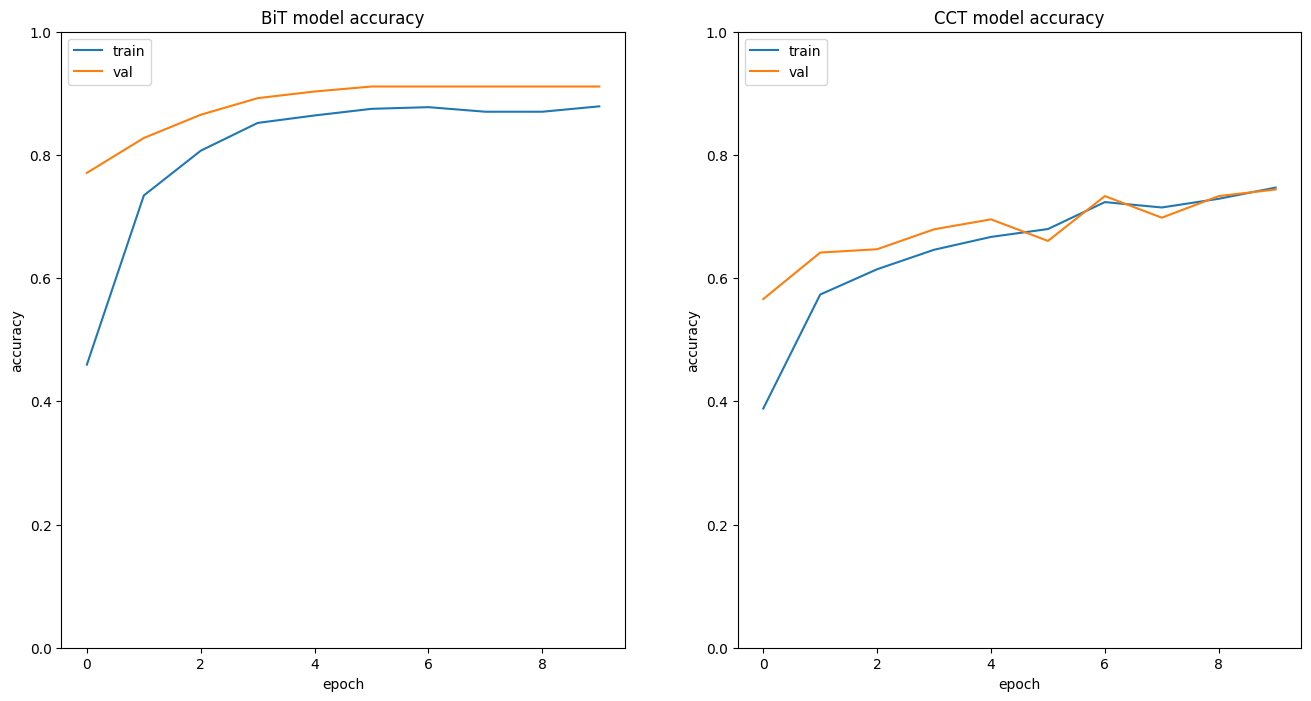

In [20]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1, ylim=(0, 1))
plot_history(bit_history, 'BiT model accuracy')
plt.subplot(1, 2, 2, ylim=(0, 1))
plot_history(cct_history, 'CCT model accuracy')
plt.show()

The CCT model had about the same number of paramaters as the BiT model, but did not perform as well. It also took a lot longer to train. BiT was also easier to set up, since it uses mostly standard tensorflow libraries. 